🔍 EV Fleet Pricing Diagnostic Tool
✅ Data loaded successfully
   Routes: 17,625 records
   Charging: 4,013 records
   Fleet: 50 vehicles

📊 DIAGNOSTIC ANALYSIS
🕐 1. TIME DISTRIBUTION ANALYSIS
----------------------------------------
Charging sessions by hour:
   0:00 - 3244 sessions 🟢 OFF
   1:00 -   0 sessions 🟢 OFF
   2:00 -   0 sessions 🟢 OFF
   3:00 -   0 sessions 🟢 OFF
   4:00 -   0 sessions 🟢 OFF
   5:00 -   0 sessions 🟢 OFF
   6:00 -   0 sessions 🟢 OFF
   7:00 -   0 sessions 🟢 OFF
   8:00 -   0 sessions 🟢 OFF
   9:00 -   0 sessions 🟢 OFF
  10:00 -   0 sessions 🟢 OFF
  11:00 -   0 sessions 🟢 OFF
  12:00 -   0 sessions 🟢 OFF
  13:00 -   0 sessions 🟢 OFF
  14:00 -   0 sessions 🟢 OFF
  15:00 -   0 sessions 🟢 OFF
  16:00 -   0 sessions 🟢 OFF
  17:00 -   0 sessions 🔴 PEAK
  18:00 -   0 sessions 🔴 PEAK
  19:00 -   0 sessions 🔴 PEAK
  20:00 - 769 sessions 🔴 PEAK
  21:00 -   0 sessions 🔴 PEAK
  22:00 -   0 sessions 🟢 OFF
  23:00 -   0 sessions 🟢 OFF

Current Peak Hours ([17, 18, 19, 20, 

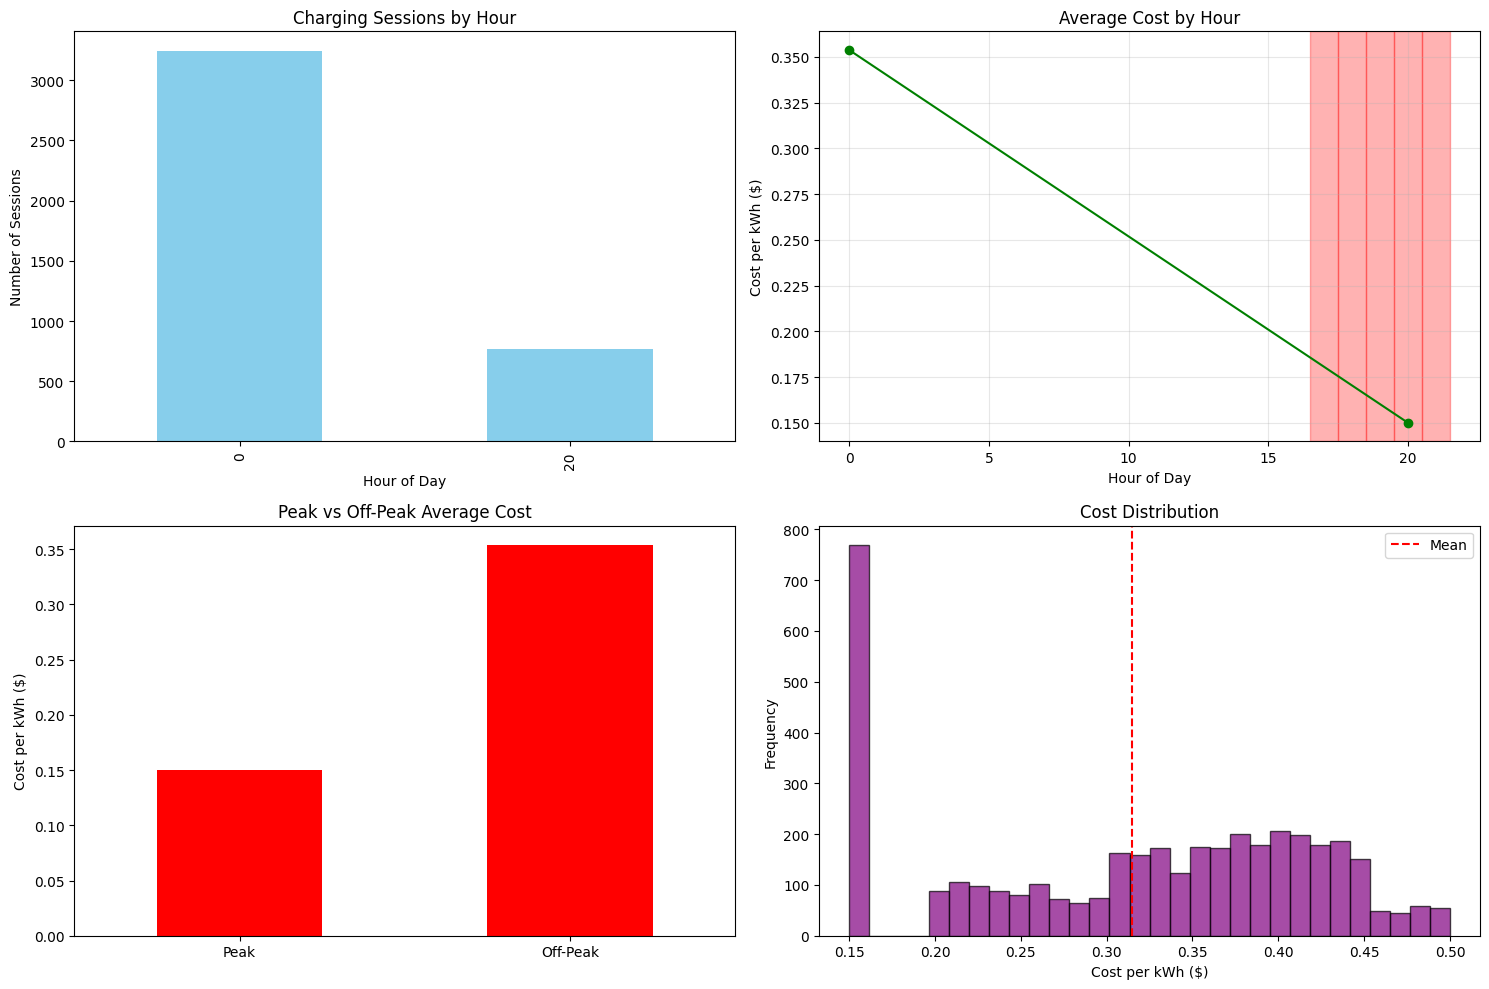


📊 DETAILED POWER-COST ANALYSIS
----------------------------------------


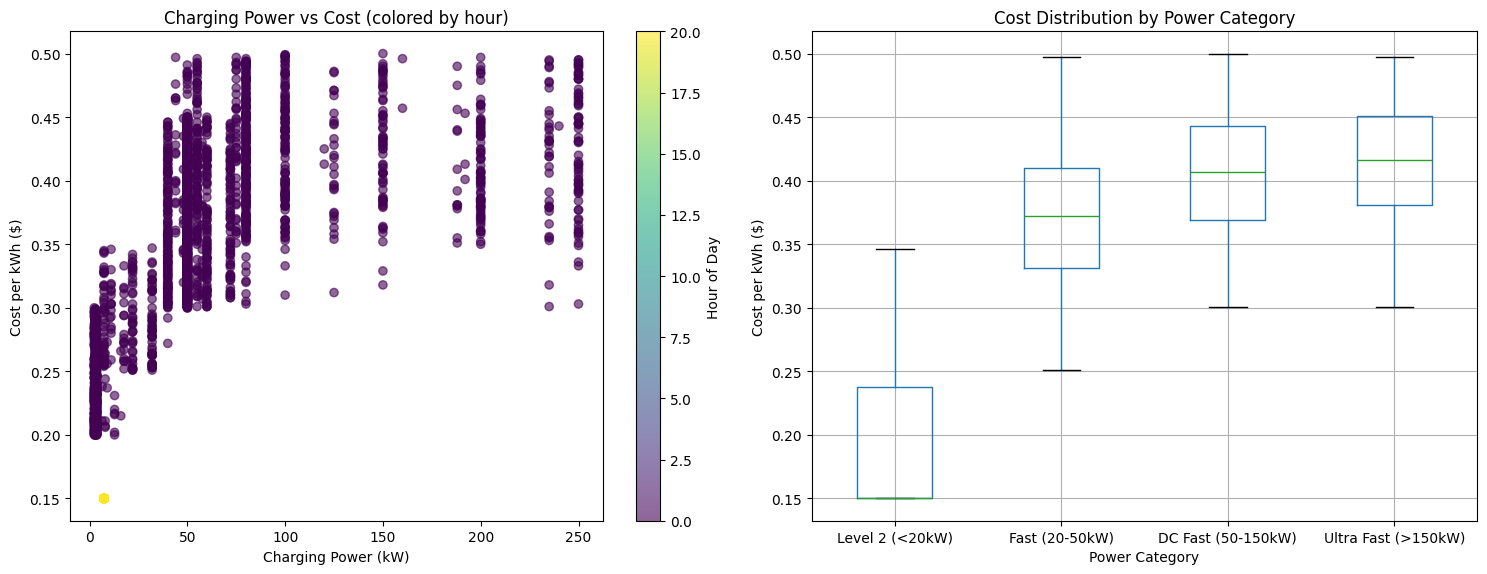


🕐 DETAILED TIME ANALYSIS
----------------------------------------


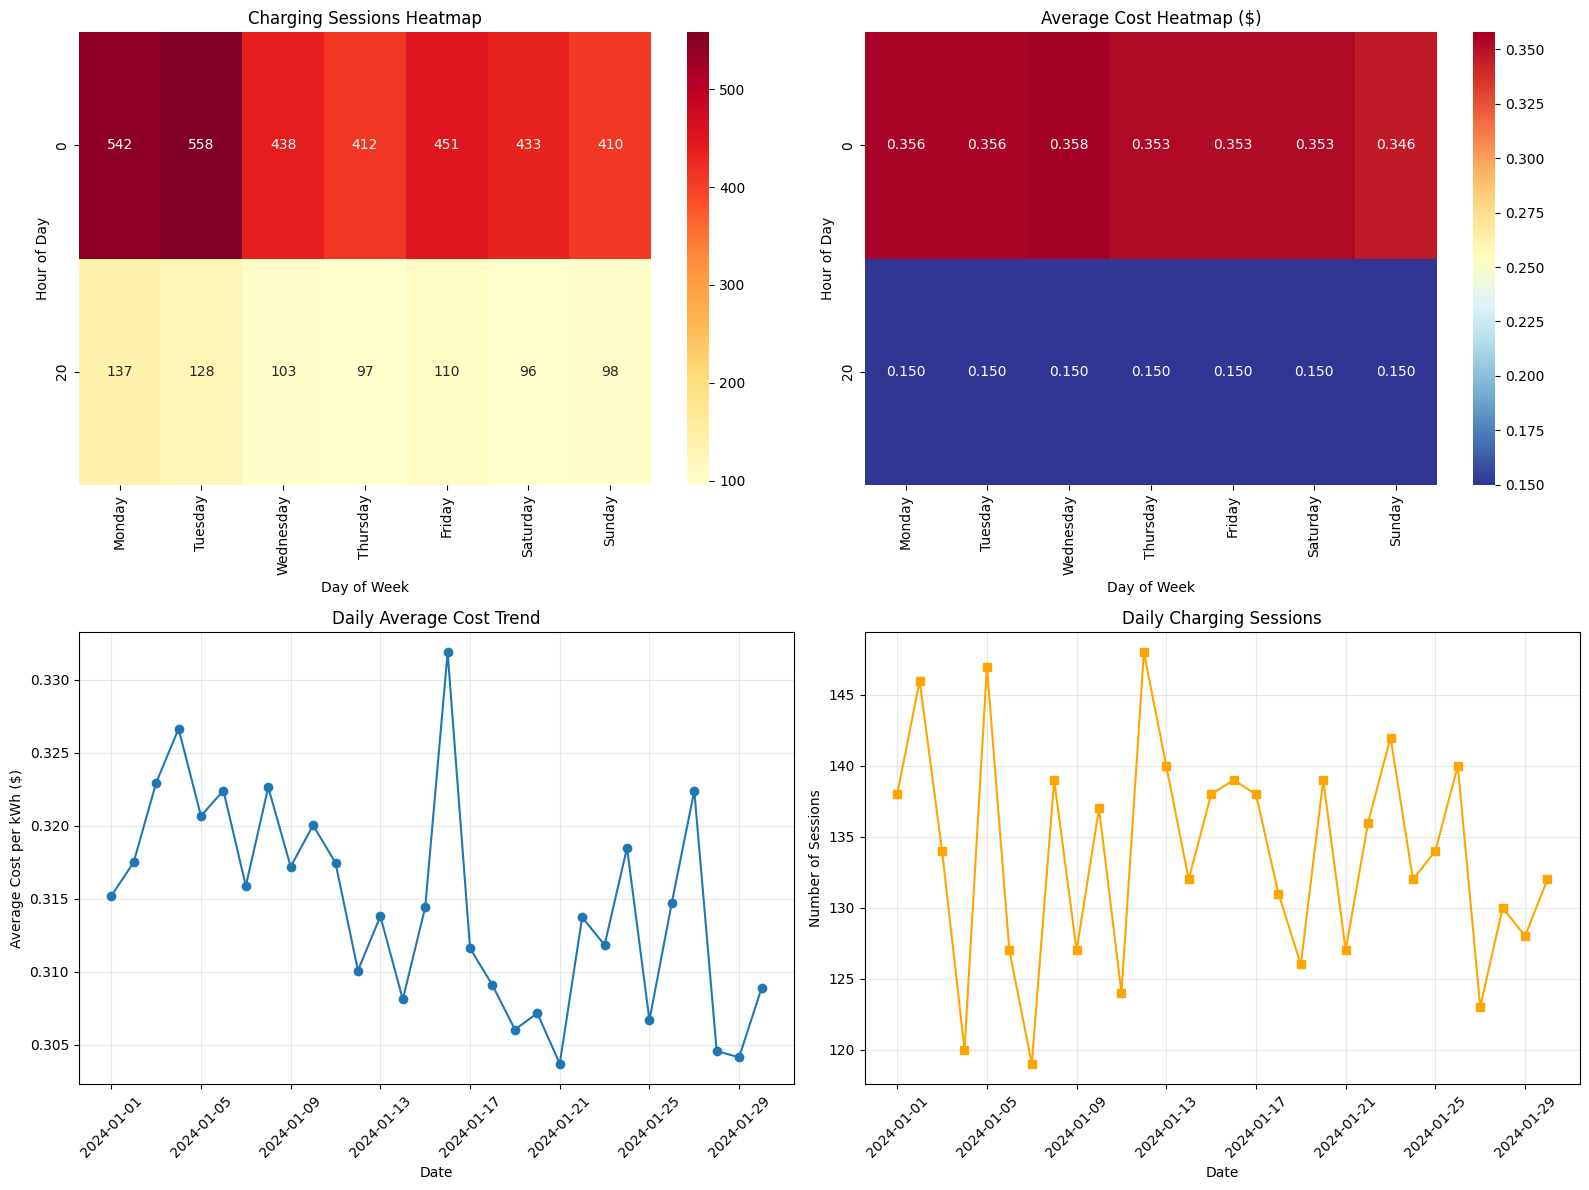


💾 EXPORTING DETAILED DATA
----------------------------------------


OSError: Cannot save file into a non-existent directory: 'data\synthetic'

In [4]:
"""
Diagnostic script to investigate peak/off-peak pricing issues
Analyzes existing synthetic data to identify root causes
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("🔍 EV Fleet Pricing Diagnostic Tool")
print("="*60)

# Load the existing data
try:
    routes = pd.read_csv('../data/synthetic/routes.csv')
    charging = pd.read_csv('../data/synthetic/charging_sessions.csv')
    fleet_info = pd.read_csv('../data/synthetic/fleet_info.csv')
    
    # Convert datetime columns with flexible parsing
    routes['date'] = pd.to_datetime(routes['date'], format='ISO8601')
    charging['start_time'] = pd.to_datetime(charging['start_time'], format='ISO8601')
    charging['end_time'] = pd.to_datetime(charging['end_time'], format='ISO8601')
    
    print(f"✅ Data loaded successfully")
    print(f"   Routes: {len(routes):,} records")
    print(f"   Charging: {len(charging):,} records")
    print(f"   Fleet: {len(fleet_info):,} vehicles")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please run the synthetic data generator first!")
    exit(1)

print("\n" + "="*60)
print("📊 DIAGNOSTIC ANALYSIS")
print("="*60)

# Extract time components
charging['hour'] = charging['start_time'].dt.hour
charging['day_of_week'] = charging['start_time'].dt.day_name()
charging['date_only'] = charging['start_time'].dt.date

# Define peak hours (current config)
PEAK_HOURS = [17, 18, 19, 20, 21]  # 5-9 PM
charging['is_peak_current'] = charging['hour'].isin(PEAK_HOURS)

# Define proposed peak hours (with morning rush)
PEAK_HOURS_PROPOSED = [7, 8, 9, 10, 17, 18, 19, 20, 21]  # 7-10 AM, 5-9 PM
charging['is_peak_proposed'] = charging['hour'].isin(PEAK_HOURS_PROPOSED)

print("🕐 1. TIME DISTRIBUTION ANALYSIS")
print("-" * 40)

# Hourly distribution
hourly_sessions = charging.groupby('hour').size()
print(f"Charging sessions by hour:")
for hour in range(24):
    count = hourly_sessions.get(hour, 0)
    is_peak = "🔴 PEAK" if hour in PEAK_HOURS else "🟢 OFF"
    print(f"  {hour:2d}:00 - {count:3d} sessions {is_peak}")

# Peak vs off-peak summary
peak_sessions = charging[charging['is_peak_current']]
offpeak_sessions = charging[~charging['is_peak_current']]

print(f"\nCurrent Peak Hours ({PEAK_HOURS}):")
print(f"  Peak sessions: {len(peak_sessions):,} ({len(peak_sessions)/len(charging):.1%})")
print(f"  Off-peak sessions: {len(offpeak_sessions):,} ({len(offpeak_sessions)/len(charging):.1%})")

print("\n🏷️ 2. PRICING ANALYSIS")
print("-" * 40)

# Basic pricing stats
print(f"Overall pricing statistics:")
print(f"  Average cost: ${charging['cost_per_kwh'].mean():.3f}/kWh")
print(f"  Min cost: ${charging['cost_per_kwh'].min():.3f}/kWh")
print(f"  Max cost: ${charging['cost_per_kwh'].max():.3f}/kWh")
print(f"  Std dev: ${charging['cost_per_kwh'].std():.3f}/kWh")

# Peak vs off-peak pricing
if len(peak_sessions) > 0 and len(offpeak_sessions) > 0:
    peak_avg = peak_sessions['cost_per_kwh'].mean()
    offpeak_avg = offpeak_sessions['cost_per_kwh'].mean()
    
    print(f"\n🔴 Peak hours pricing:")
    print(f"  Average: ${peak_avg:.3f}/kWh")
    print(f"  Min: ${peak_sessions['cost_per_kwh'].min():.3f}/kWh")
    print(f"  Max: ${peak_sessions['cost_per_kwh'].max():.3f}/kWh")
    print(f"  Std dev: ${peak_sessions['cost_per_kwh'].std():.3f}/kWh")
    
    print(f"\n🟢 Off-peak hours pricing:")
    print(f"  Average: ${offpeak_avg:.3f}/kWh")
    print(f"  Min: ${offpeak_sessions['cost_per_kwh'].min():.3f}/kWh")
    print(f"  Max: ${offpeak_sessions['cost_per_kwh'].max():.3f}/kWh")
    print(f"  Std dev: ${offpeak_sessions['cost_per_kwh'].std():.3f}/kWh")
    
    # The key diagnostic
    if peak_avg > offpeak_avg:
        print(f"\n✅ Peak pricing is CORRECT: {((peak_avg/offpeak_avg - 1) * 100):+.1f}% premium")
    else:
        print(f"\n❌ Peak pricing is BROKEN: {((peak_avg/offpeak_avg - 1) * 100):+.1f}% discount (!)")
        print(f"   Peak should be MORE expensive than off-peak!")

print("\n⚡ 3. CHARGING POWER ANALYSIS")
print("-" * 40)

# Power distribution by time
if 'charging_power_kw' in charging.columns:
    peak_power = peak_sessions['charging_power_kw'].mean()
    offpeak_power = offpeak_sessions['charging_power_kw'].mean()
    
    print(f"Average charging power:")
    print(f"  Peak hours: {peak_power:.1f} kW")
    print(f"  Off-peak hours: {offpeak_power:.1f} kW")
    
    # Power categories
    charging['power_category'] = pd.cut(charging['charging_power_kw'], 
                                       bins=[0, 20, 50, 150, 1000],
                                       labels=['Level 2 (<20kW)', 'Fast (20-50kW)', 
                                              'DC Fast (50-150kW)', 'Ultra Fast (>150kW)'])
    
    power_by_time = pd.crosstab(charging['is_peak_current'], charging['power_category'])
    print(f"\nCharging power distribution:")
    print(power_by_time)
    
    # This is the key diagnostic - are different power levels chosen at different times?
    print(f"\nPower category percentages:")
    power_pct = pd.crosstab(charging['is_peak_current'], charging['power_category'], normalize='index') * 100
    print(power_pct.round(1))
    
else:
    print("⚠️ Charging power data not available")

print("\n🏪 4. STATION TYPE ANALYSIS")
print("-" * 40)

if 'charging_type' in charging.columns:
    # Charging type distribution by time
    type_by_time = pd.crosstab(charging['is_peak_current'], charging['charging_type'])
    print(f"Charging type distribution:")
    print(type_by_time)
    
    type_pct = pd.crosstab(charging['is_peak_current'], charging['charging_type'], normalize='index') * 100
    print(f"\nCharging type percentages:")
    print(type_pct.round(1))
    
    # Cost by charging type and time
    cost_analysis = charging.groupby(['is_peak_current', 'charging_type'])['cost_per_kwh'].agg(['mean', 'count']).round(3)
    print(f"\nCost by charging type and time:")
    print(cost_analysis)
    
else:
    print("⚠️ Charging type data not available")

print("\n🚗 5. DRIVER BEHAVIOR ANALYSIS")
print("-" * 40)

# Merge with fleet info for driver analysis
charging_detailed = charging.merge(fleet_info[['vehicle_id', 'driver_profile']], on='vehicle_id', how='left')

if 'driver_profile' in charging_detailed.columns:
    # Driver behavior by time
    driver_by_time = pd.crosstab(charging_detailed['is_peak_current'], charging_detailed['driver_profile'])
    print(f"Driver profile distribution by time:")
    print(driver_by_time)
    
    driver_pct = pd.crosstab(charging_detailed['is_peak_current'], charging_detailed['driver_profile'], normalize='index') * 100
    print(f"\nDriver profile percentages:")
    print(driver_pct.round(1))
    
    # Cost by driver profile and time
    driver_cost = charging_detailed.groupby(['is_peak_current', 'driver_profile'])['cost_per_kwh'].agg(['mean', 'count']).round(3)
    print(f"\nCost by driver profile and time:")
    print(driver_cost)

print("\n📍 6. LOCATION ANALYSIS")
print("-" * 40)

if 'station_operator' in charging.columns:
    # Operator distribution by time
    operator_by_time = pd.crosstab(charging['is_peak_current'], charging['station_operator'])
    print(f"Top station operators by time:")
    print(operator_by_time.head())
    
    # Cost by operator and time
    operator_cost = charging.groupby(['is_peak_current', 'station_operator'])['cost_per_kwh'].agg(['mean', 'count']).round(3)
    print(f"\nCost by operator and time (top 5):")
    print(operator_cost.head())

print("\n📈 7. STATISTICAL TESTS")
print("-" * 40)

from scipy import stats

# T-test for peak vs off-peak pricing
if len(peak_sessions) > 0 and len(offpeak_sessions) > 0:
    t_stat, p_value = stats.ttest_ind(peak_sessions['cost_per_kwh'], offpeak_sessions['cost_per_kwh'])
    print(f"T-test for peak vs off-peak pricing:")
    print(f"  T-statistic: {t_stat:.3f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Correlation analysis
correlations = charging[['hour', 'cost_per_kwh', 'charging_power_kw', 'energy_delivered_kwh']].corr()
print(f"\nCorrelation matrix:")
print(correlations.round(3))

print("\n🎯 8. ROOT CAUSE DIAGNOSIS")
print("-" * 40)

# Diagnose the most likely causes
issues_found = []

# Check 1: Time distribution
peak_ratio = len(peak_sessions) / len(charging)
if peak_ratio < 0.15 or peak_ratio > 0.35:
    issues_found.append(f"⚠️ Unusual peak hour ratio: {peak_ratio:.1%} (expected ~20-25%)")

# Check 2: Pricing direction
if len(peak_sessions) > 0 and len(offpeak_sessions) > 0:
    if peak_sessions['cost_per_kwh'].mean() <= offpeak_sessions['cost_per_kwh'].mean():
        issues_found.append("❌ Peak pricing is backwards (peak ≤ off-peak)")

# Check 3: Power correlation
if 'charging_power_kw' in charging.columns:
    power_cost_corr = charging['charging_power_kw'].corr(charging['cost_per_kwh'])
    if abs(power_cost_corr) > 0.5:
        issues_found.append(f"⚠️ Strong power-cost correlation: {power_cost_corr:.3f}")

# Check 4: Time-power correlation
if 'charging_power_kw' in charging.columns:
    time_power_corr = charging['hour'].corr(charging['charging_power_kw'])
    if abs(time_power_corr) > 0.3:
        issues_found.append(f"⚠️ Time-power correlation: {time_power_corr:.3f}")

if issues_found:
    print("Issues detected:")
    for issue in issues_found:
        print(f"  {issue}")
else:
    print("✅ No obvious issues detected")

print("\n💡 9. RECOMMENDATIONS")
print("-" * 40)

print("Based on the analysis above:")
print("1. Check if station selection varies by time of day")
print("2. Verify peak hour multiplier is applied correctly")
print("3. Ensure base costs represent off-peak rates")
print("4. Consider driver behavior patterns in charging timing")
print("5. Validate charging power distribution makes sense")

print("\n" + "="*60)
print("🏁 DIAGNOSTIC COMPLETE")
print("="*60)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Hourly charging distribution
hourly_sessions.plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Charging Sessions by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Number of Sessions')
# Highlight peak hours
for hour in PEAK_HOURS:
    axes[0,0].axvspan(hour-0.5, hour+0.5, alpha=0.3, color='red')

# 2. Cost by hour
hourly_cost = charging.groupby('hour')['cost_per_kwh'].mean()
hourly_cost.plot(kind='line', ax=axes[0,1], marker='o', color='green')
axes[0,1].set_title('Average Cost by Hour')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Cost per kWh ($)')
axes[0,1].grid(True, alpha=0.3)
# Highlight peak hours
for hour in PEAK_HOURS:
    axes[0,1].axvspan(hour-0.5, hour+0.5, alpha=0.3, color='red')

# 3. Peak vs off-peak comparison
if len(peak_sessions) > 0 and len(offpeak_sessions) > 0:
    comparison_data = pd.DataFrame({
        'Peak': [peak_sessions['cost_per_kwh'].mean()],
        'Off-Peak': [offpeak_sessions['cost_per_kwh'].mean()]
    })
    comparison_data.T.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
    axes[1,0].set_title('Peak vs Off-Peak Average Cost')
    axes[1,0].set_ylabel('Cost per kWh ($)')
    axes[1,0].tick_params(axis='x', rotation=0)
    axes[1,0].legend().set_visible(False)

# 4. Cost distribution
axes[1,1].hist(charging['cost_per_kwh'], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].axvline(charging['cost_per_kwh'].mean(), color='red', linestyle='--', label='Mean')
axes[1,1].set_title('Cost Distribution')
axes[1,1].set_xlabel('Cost per kWh ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.savefig('../data/synthetic/pricing_diagnostic.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed analysis if charging power data exists
if 'charging_power_kw' in charging.columns:
    print("\n📊 DETAILED POWER-COST ANALYSIS")
    print("-" * 40)
    
    # Create power-cost scatter plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter plot: Power vs Cost
    scatter = axes[0].scatter(charging['charging_power_kw'], charging['cost_per_kwh'], 
                             c=charging['hour'], cmap='viridis', alpha=0.6)
    axes[0].set_xlabel('Charging Power (kW)')
    axes[0].set_ylabel('Cost per kWh ($)')
    axes[0].set_title('Charging Power vs Cost (colored by hour)')
    plt.colorbar(scatter, ax=axes[0], label='Hour of Day')
    
    # Box plot: Cost by power category
    if 'power_category' in charging.columns:
        charging.boxplot(column='cost_per_kwh', by='power_category', ax=axes[1])
        axes[1].set_title('Cost Distribution by Power Category')
        axes[1].set_xlabel('Power Category')
        axes[1].set_ylabel('Cost per kWh ($)')
        plt.suptitle('')  # Remove automatic title
    
    plt.tight_layout()
    plt.savefig('../data/synthetic/power_cost_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Time-based analysis
print("\n🕐 DETAILED TIME ANALYSIS")
print("-" * 40)

# Create comprehensive time analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Sessions by day of week and hour (heatmap)
if len(charging) > 100:  # Only if we have enough data
    pivot_data = charging.pivot_table(values='session_id', 
                                     index='hour', 
                                     columns='day_of_week',
                                     aggfunc='count', 
                                     fill_value=0)
    
    # Reorder columns to start with Monday
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_data = pivot_data.reindex(columns=[d for d in day_order if d in pivot_data.columns])
    
    sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0,0])
    axes[0,0].set_title('Charging Sessions Heatmap')
    axes[0,0].set_xlabel('Day of Week')
    axes[0,0].set_ylabel('Hour of Day')

# 2. Average cost by day of week and hour
if len(charging) > 100:
    cost_pivot = charging.pivot_table(values='cost_per_kwh', 
                                     index='hour', 
                                     columns='day_of_week',
                                     aggfunc='mean')
    
    cost_pivot = cost_pivot.reindex(columns=[d for d in day_order if d in cost_pivot.columns])
    
    sns.heatmap(cost_pivot, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=axes[0,1])
    axes[0,1].set_title('Average Cost Heatmap ($)')
    axes[0,1].set_xlabel('Day of Week')
    axes[0,1].set_ylabel('Hour of Day')

# 3. Cost trend over time
charging_daily = charging.groupby('date_only').agg({
    'cost_per_kwh': 'mean',
    'session_id': 'count'
}).reset_index()

axes[1,0].plot(charging_daily['date_only'], charging_daily['cost_per_kwh'], marker='o')
axes[1,0].set_title('Daily Average Cost Trend')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Average Cost per kWh ($)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Sessions per day trend
axes[1,1].plot(charging_daily['date_only'], charging_daily['session_id'], marker='s', color='orange')
axes[1,1].set_title('Daily Charging Sessions')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Number of Sessions')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/synthetic/time_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Export detailed analysis to CSV for further investigation
print("\n💾 EXPORTING DETAILED DATA")
print("-" * 40)

# Create analysis summary
analysis_summary = pd.DataFrame({
    'Metric': [
        'Total Sessions',
        'Peak Sessions',
        'Off-Peak Sessions',
        'Peak Percentage',
        'Average Cost (All)',
        'Average Cost (Peak)',
        'Average Cost (Off-Peak)',
        'Peak Premium/Discount',
        'Cost Std Dev',
        'Min Cost',
        'Max Cost'
    ],
    'Value': [
        len(charging),
        len(peak_sessions),
        len(offpeak_sessions),
        f"{len(peak_sessions)/len(charging):.1%}",
        f"${charging['cost_per_kwh'].mean():.3f}",
        f"${peak_sessions['cost_per_kwh'].mean():.3f}" if len(peak_sessions) > 0 else "N/A",
        f"${offpeak_sessions['cost_per_kwh'].mean():.3f}" if len(offpeak_sessions) > 0 else "N/A",
        f"{((peak_sessions['cost_per_kwh'].mean()/offpeak_sessions['cost_per_kwh'].mean() - 1) * 100):+.1f}%" if len(peak_sessions) > 0 and len(offpeak_sessions) > 0 else "N/A",
        f"${charging['cost_per_kwh'].std():.3f}",
        f"${charging['cost_per_kwh'].min():.3f}",
        f"${charging['cost_per_kwh'].max():.3f}"
    ]
})

analysis_summary.to_csv('data/synthetic/pricing_analysis_summary.csv', index=False)
print("✅ Analysis summary saved to: data/synthetic/pricing_analysis_summary.csv")

# Export hourly breakdown
hourly_breakdown = charging.groupby('hour').agg({
    'session_id': 'count',
    'cost_per_kwh': ['mean', 'std', 'min', 'max'],
    'energy_delivered_kwh': 'mean',
    'charging_power_kw': 'mean' if 'charging_power_kw' in charging.columns else lambda x: None
}).round(3)

hourly_breakdown.columns = ['_'.join(col).strip() if col[1] else col[0] for col in hourly_breakdown.columns]
hourly_breakdown['is_peak'] = hourly_breakdown.index.isin(PEAK_HOURS)
hourly_breakdown.to_csv('data/synthetic/hourly_pricing_breakdown.csv')
print("✅ Hourly breakdown saved to: data/synthetic/hourly_pricing_breakdown.csv")

# Export station analysis if available
if 'station_operator' in charging.columns:
    station_analysis = charging.groupby('station_operator').agg({
        'session_id': 'count',
        'cost_per_kwh': ['mean', 'std'],
        'charging_power_kw': 'mean' if 'charging_power_kw' in charging.columns else lambda x: None,
        'energy_delivered_kwh': 'mean'
    }).round(3)
    
    station_analysis.columns = ['_'.join(col).strip() if col[1] else col[0] for col in station_analysis.columns]
    station_analysis = station_analysis.sort_values('session_id_count', ascending=False)
    station_analysis.to_csv('data/synthetic/station_analysis.csv')
    print("✅ Station analysis saved to: data/synthetic/station_analysis.csv")

print("\n🎯 FINAL DIAGNOSIS")
print("="*60)

# Provide specific diagnosis based on findings
if len(peak_sessions) > 0 and len(offpeak_sessions) > 0:
    peak_avg = peak_sessions['cost_per_kwh'].mean()
    offpeak_avg = offpeak_sessions['cost_per_kwh'].mean()
    
    if peak_avg <= offpeak_avg:
        print("🚨 CONFIRMED ISSUE: Peak pricing is backwards!")
        print(f"   Peak average: ${peak_avg:.3f}/kWh")
        print(f"   Off-peak average: ${offpeak_avg:.3f}/kWh")
        print(f"   Difference: {((peak_avg/offpeak_avg - 1) * 100):+.1f}%")
        
        # Investigate potential causes
        print("\n🔍 POTENTIAL CAUSES:")
        
        # Check power distribution
        if 'charging_power_kw' in charging.columns:
            peak_power_avg = peak_sessions['charging_power_kw'].mean()
            offpeak_power_avg = offpeak_sessions['charging_power_kw'].mean()
            
            if peak_power_avg < offpeak_power_avg:
                print(f"   1. Lower power stations during peak ({peak_power_avg:.1f}kW vs {offpeak_power_avg:.1f}kW)")
            
        # Check charging type distribution
        if 'charging_type' in charging.columns:
            peak_home_pct = (peak_sessions['charging_type'] == 'home').mean()
            offpeak_home_pct = (offpeak_sessions['charging_type'] == 'home').mean()
            
            if peak_home_pct > offpeak_home_pct:
                print(f"   2. More home charging during peak ({peak_home_pct:.1%} vs {offpeak_home_pct:.1%})")
        
        # Check station operator distribution
        if 'station_operator' in charging.columns:
            peak_operators = peak_sessions['station_operator'].value_counts(normalize=True).head(3)
            offpeak_operators = offpeak_sessions['station_operator'].value_counts(normalize=True).head(3)
            print(f"   3. Different operators: Peak uses {peak_operators.index[0]} ({peak_operators.iloc[0]:.1%})")
            print(f"                          Off-peak uses {offpeak_operators.index[0]} ({offpeak_operators.iloc[0]:.1%})")
        
        print("\n💡 RECOMMENDED FIXES:")
        print("   1. Ensure base costs represent OFF-PEAK rates")
        print("   2. Apply peak multiplier correctly to base costs")
        print("   3. Validate station selection doesn't bias by time")
        print("   4. Check charging type assignment logic")
        
    else:
        print("✅ Peak pricing is working correctly!")
        print(f"   Peak premium: {((peak_avg/offpeak_avg - 1) * 100):+.1f}%")

print(f"\n📁 All diagnostic files saved to: data/synthetic/")
print(f"📊 Charts saved as PNG files for review")
print(f"📈 Run this script again after making fixes to verify improvements")

print("\n" + "="*60)
print("🏁 DIAGNOSTIC SCRIPT COMPLETE")
print("="*60)



=== CHARGING DATA EXAMINATION ===
Charging dataset shape: (4013, 20)
Charging columns: ['session_id', 'vehicle_id', 'charging_type', 'station_id', 'station_operator', 'location', 'start_time', 'end_time', 'start_soc', 'end_soc', 'energy_delivered_kwh', 'charging_power_kw', 'duration_hours', 'cost_usd', 'cost_per_kwh', 'is_emergency_charging', 'connector_type', 'hour', 'station_lat', 'station_lon']

First few rows of charging data:
                    session_id vehicle_id charging_type station_id  \
0  EV_000_20240101_0000_public     EV_000        public     140958   
1  EV_000_20240101_0000_public     EV_000        public     294113   
2  EV_000_20240101_0000_public     EV_000        public     340595   
3  EV_000_20240101_0000_public     EV_000        public     294060   
4  EV_000_20240101_0000_public     EV_000        public     311508   

              station_operator                  location start_time  \
0                 eVgo Network  (37.795402, -122.262753) 2024-01-01   
1 

=== CHARGING DATA EXAMINATION ===
Charging dataset shape: (4013, 20)
Charging columns: ['session_id', 'vehicle_id', 'charging_type', 'station_id', 'station_operator', 'location', 'start_time', 'end_time', 'start_soc', 'end_soc', 'energy_delivered_kwh', 'charging_power_kw', 'duration_hours', 'cost_usd', 'cost_per_kwh', 'is_emergency_charging', 'connector_type', 'hour', 'station_lat', 'station_lon']

First few rows of charging data:
                    session_id vehicle_id charging_type station_id  \
0  EV_000_20240101_0000_public     EV_000        public     140958   
1  EV_000_20240101_0000_public     EV_000        public     294113   
2  EV_000_20240101_0000_public     EV_000        public     340595   
3  EV_000_20240101_0000_public     EV_000        public     294060   
4  EV_000_20240101_0000_public     EV_000        public     311508   

              station_operator                  location start_time  \
0                 eVgo Network  (37.795402, -122.262753) 2024-01-01   
1 